In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random Seed set to {seed}")

set_seed(42)

Random Seed set to 42


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- 1. DATA LOADING & PREPROCESSING ---

# Load the dataset
df = pd.read_csv('classData.csv')

# A. Create the 'Label' column based on G, C, B, A flags
# Mapping: 0 = Normal, 1 = Short Circuit, 2 = Ground Fault
def get_label(row):
    if row['G'] == 1:
        return 2 # Ground Fault (Priority to Ground)
    elif row['A'] == 1 or row['B'] == 1 or row['C'] == 1:
        return 1 # Short Circuit (Fault but no Ground)
    else:
        return 0 # Normal

df['Label'] = df.apply(get_label, axis=1)

# Define Class Names for later visualization
classes = ['Normal', 'Short Circuit', 'Ground Fault']

# B. Select Features (3 Currents, 3 Voltages)
feature_cols = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
data_values = df[feature_cols].values
labels = df['Label'].values

# C. Normalize Data (Crucial for convergence)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_values)

# D. Create Time-Series Windows (Sliding Window)
# We convert continuous data into blocks of 'window_size' time steps
window_size = 50  # Look at 50ms (or time steps) of history
stride = 10       # Move forward by 10 steps for next window

X_windows = []
y_windows = []

# Iterate through data to create sequences
for i in range(0, len(data_scaled) - window_size, stride):
    # Extract window of features
    window = data_scaled[i : i + window_size]
    
    # Extract label (we take the label of the last timestamp in the window)
    label = labels[i + window_size - 1]
    
    X_windows.append(window)
    y_windows.append(label)

X_windows = np.array(X_windows)
y_windows = np.array(y_windows)

# Reshape for PyTorch: (Samples, Channels, Length)
# Current shape: (N, 50, 6) -> Target shape: (N, 6, 50)
X_windows = X_windows.transpose(0, 2, 1)

print(f"Data Processed. Final Shape: {X_windows.shape}")
print(f"Total Samples: {len(y_windows)}")

# --- 2. TRAIN/TEST SPLIT ---
# Stratify ensures we have equal proportions of faults in train and test
X_train, X_temp, y_train, y_temp = train_test_split(X_windows, y_windows, test_size=0.3, random_state=42, stratify=y_windows)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to PyTorch Tensors
train_dataset = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Data Processed. Final Shape: (782, 6, 50)
Total Samples: 782


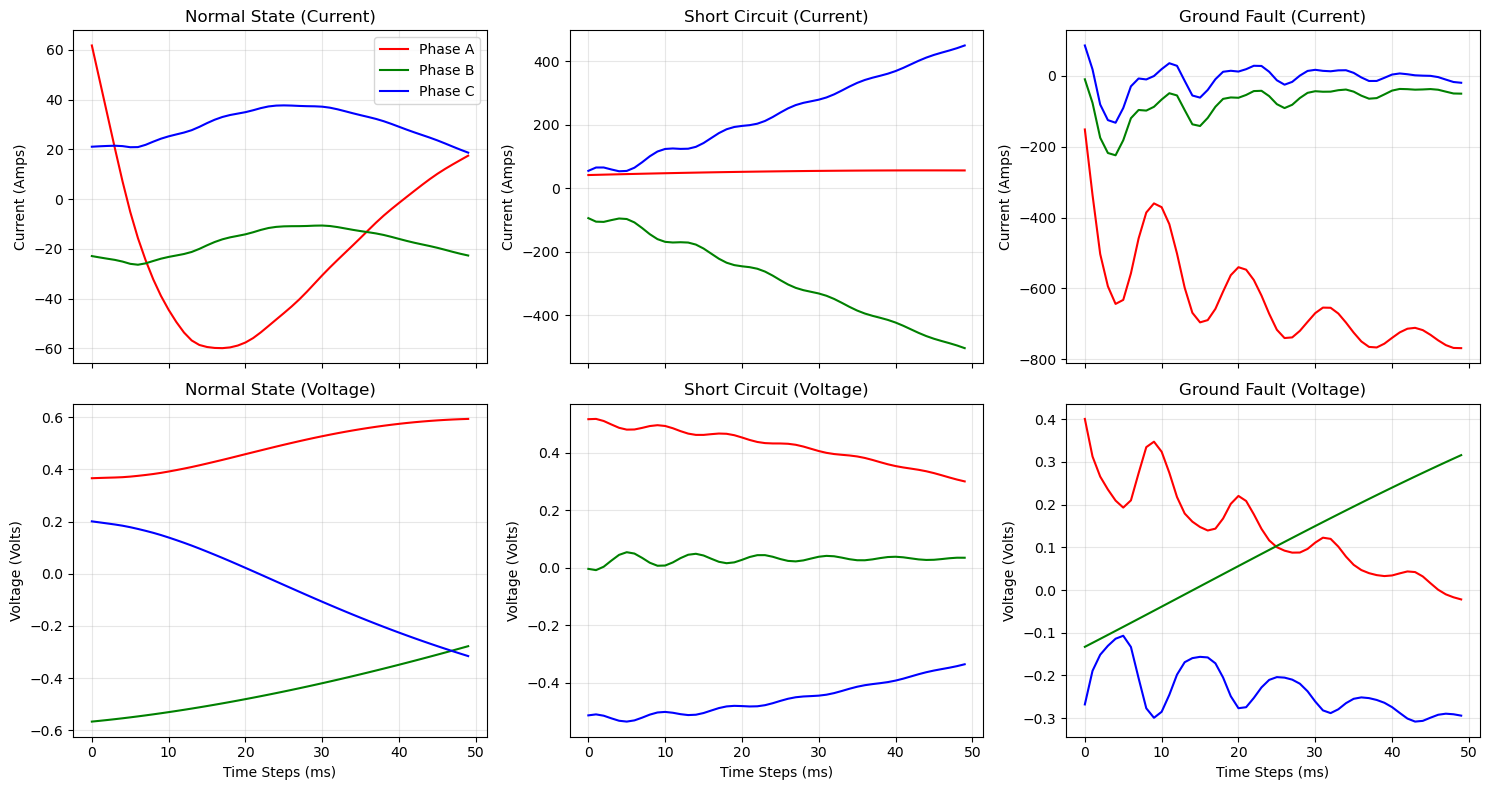

In [3]:
# --- CELL 1.5: EXPLORATORY DATA ANALYSIS (EDA) ---
import matplotlib.pyplot as plt

# We use the raw dataframe 'df' to see the physical values (Amps/Volts)
# Function to find a continuous 50-step window for a specific class
def get_sample_window(target_label, window_size=50):
    # Get all indices for this class
    indices = df[df['Label'] == target_label].index.tolist()
    
    # Find a continuous sequence (e.g., 50 consecutive timestamps)
    for i in range(len(indices) - window_size):
        if indices[i+window_size-1] - indices[i] == window_size - 1:
            start = indices[i]
            return df.iloc[start : start+window_size]
    return None

# Extract samples
sample_normal = get_sample_window(0) # Normal
sample_short  = get_sample_window(1) # Short Circuit
sample_ground = get_sample_window(2) # Ground Fault

# Create the Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
titles = ['Normal State', 'Short Circuit', 'Ground Fault']
samples = [sample_normal, sample_short, sample_ground]

# Row 1: Currents (Ia, Ib, Ic)
for i in range(3):
    if samples[i] is not None:
        axes[0, i].plot(samples[i]['Ia'].values, label='Phase A', color='r')
        axes[0, i].plot(samples[i]['Ib'].values, label='Phase B', color='g')
        axes[0, i].plot(samples[i]['Ic'].values, label='Phase C', color='b')
        axes[0, i].set_title(f"{titles[i]} (Current)")
        axes[0, i].set_ylabel("Current (Amps)")
        axes[0, i].grid(True, alpha=0.3)
        if i==0: axes[0, i].legend(loc='upper right')

# Row 2: Voltages (Va, Vb, Vc)
for i in range(3):
    if samples[i] is not None:
        axes[1, i].plot(samples[i]['Va'].values, label='Phase A', color='r')
        axes[1, i].plot(samples[i]['Vb'].values, label='Phase B', color='g')
        axes[1, i].plot(samples[i]['Vc'].values, label='Phase C', color='b')
        axes[1, i].set_title(f"{titles[i]} (Voltage)")
        axes[1, i].set_xlabel("Time Steps (ms)")
        axes[1, i].set_ylabel("Voltage (Volts)")
        axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
import torch.nn as nn

class FaultDetectorCNN(nn.Module):
    def __init__(self):
        super(FaultDetectorCNN, self).__init__()
        
        # Layer 1: Input has 6 channels (Ia, Ib, Ic, Va, Vb, Vc)
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Layer 2
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()

        # Fully Connected Layer calculation:
        # Window size 50 -> Pool(2) -> 25 -> Pool(2) -> 12
        # 32 output channels * 12 length = 384 inputs to Dense Layer
        self.fc1 = nn.Linear(32 * 12, 64) 
        self.fc2 = nn.Linear(64, 3) # Output: 3 Classes

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = FaultDetectorCNN()
print(model)

FaultDetectorCNN(
  (conv1): Conv1d(6, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=384, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


Starting Training...
Epoch 5/15, Train Loss: 0.3714, Val Loss: 0.3886
Epoch 10/15, Train Loss: 0.2489, Val Loss: 0.3333
Epoch 15/15, Train Loss: 0.2289, Val Loss: 0.2635


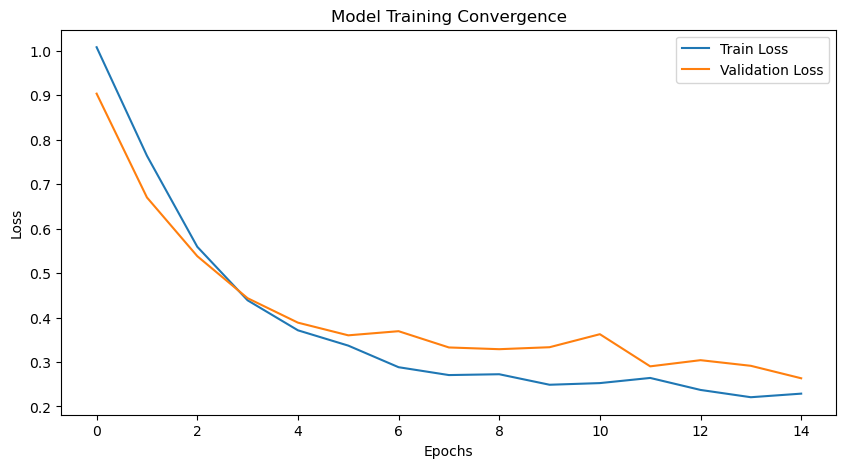

In [5]:
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15 # Increased slightly for real data
train_losses = []
val_losses = []

print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Model Training Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

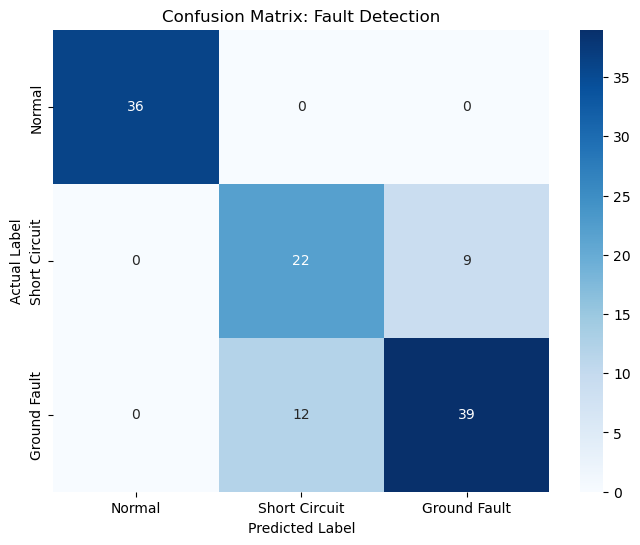


Classification Report:
               precision    recall  f1-score   support

       Normal       1.00      1.00      1.00        36
Short Circuit       0.65      0.71      0.68        31
 Ground Fault       0.81      0.76      0.79        51

     accuracy                           0.82       118
    macro avg       0.82      0.82      0.82       118
 weighted avg       0.83      0.82      0.82       118



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix: Fault Detection")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

In [9]:
# --- CELL 5: EXPLAINABLE AI (ROBUST SHAP) ---
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1. Define a generic prediction wrapper
# KernelExplainer expects 2D input (Samples, Features)
def model_predict(data_flattened):
    # Reshape back to (Batch, 6, 50) for the CNN
    data_reshaped = data_flattened.reshape(-1, 6, 50)
    data_tensor = torch.Tensor(data_reshaped)
    
    model.eval()
    with torch.no_grad():
        outputs = model(data_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    return probs.numpy()

# 2. Prepare Background Data
# We use 20 samples from training to set the baseline
background = X_train[:20].reshape(20, -1)

# 3. Initialize KernelExplainer
# This method is "Model Agnostic" and avoids PyTorch layer mismatch errors
explainer = shap.KernelExplainer(model_predict, background)

# 4. Calculate SHAP values for a single test sample
test_idx = 0 
test_sample_flat = X_test[test_idx:test_idx+1].reshape(1, -1)

print("Calculating SHAP values... (this might take a minute)")
shap_values = explainer.shap_values(test_sample_flat, nsamples=100)

# 5. ROBUST EXTRACTION Logic
# Detect if shap_values is a List (standard) or Array (edge case)
probs = model_predict(test_sample_flat)
predicted_idx = int(np.argmax(probs))
true_label = classes[y_test[test_idx]]
pred_label = classes[predicted_idx]

if isinstance(shap_values, list):
    # Standard Case: List of [Class0_Array, Class1_Array, Class2_Array]
    # Each array is (Samples, Features) -> (1, 300)
    print("SHAP output format: List")
    shap_val_instance = shap_values[predicted_idx][0]
else:
    # Edge Case: Numpy Array of shape (Samples, Features, Classes) -> (1, 300, 3)
    print(f"SHAP output format: Array {shap_values.shape}")
    if len(shap_values.shape) == 3:
        # We want Sample 0, All Features, Predicted Class Index
        shap_val_instance = shap_values[0, :, predicted_idx]
    else:
        # Fallback for single output
        shap_val_instance = shap_values[0]

# 6. Visualization
# Reshape the flat SHAP values (300,) back to (6, 50)
shap_val_matrix = shap_val_instance.reshape(6, 50)

print(f"True Label: {true_label} | Predicted: {pred_label}")
print("Red = Increases Fault Risk | Blue = Lowers Fault Risk")

plt.figure(figsize=(12, 5))
plt.imshow(shap_val_matrix, aspect='auto', cmap='coolwarm')
plt.yticks(ticks=range(6), labels=['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'])
plt.xlabel("Time Steps (Window)")
plt.colorbar(label="Feature Importance (SHAP)")
plt.title(f"Why did the model predict {pred_label}?")
plt.tight_layout()
plt.show()

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.3.

In [ ]:
# --- CELL 6: MODEL OPTIMIZATION (QUANTIZATION) ---
import os

# 1. Save original full model
torch.save(model.state_dict(), "model_full.pth")
size_full = os.path.getsize("model_full.pth") / 1024 # KB

# 2. Quantize (Compress)
# We convert 32-bit floating point weights to 8-bit integers
quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.Linear, nn.Conv1d}, dtype=torch.qint8
)

# 3. Save quantized model
torch.save(quantized_model.state_dict(), "model_quant.pth")
size_quant = os.path.getsize("model_quant.pth") / 1024 # KB

print(f"Original Size:  {size_full:.2f} KB")
print(f"Optimized Size: {size_quant:.2f} KB")
print(f"Reduction:      {(1 - size_quant/size_full)*100:.1f}%")
print("Conclusion: Quantization successful. Ready for microcontroller deployment.")

In [ ]:
# --- CELL 7: DEPLOYMENT READINESS CHECK (LATENCY) ---
import time

# Measure inference speed
input_sample = torch.Tensor(X_test[0:1])
model.eval()

# Warm up (run once to load into memory)
with torch.no_grad():
    _ = model(input_sample)

# Timing loop
start_time = time.time()
with torch.no_grad():
    for _ in range(100): 
        _ = model(input_sample)
end_time = time.time()

avg_time_ms = ((end_time - start_time) / 100) * 1000

print(f"Average Inference Time: {avg_time_ms:.4f} ms")

# ABB / Power Grid Context
# 50Hz AC cycle = 20ms period.
if avg_time_ms < 5:
    print("SUCCESS: Extremely Fast (<5ms). Suitable for real-time relay protection.")
elif avg_time_ms < 20:
    print("SUCCESS: Fast (<20ms). Suitable for cycle-by-cycle monitoring.")
else:
    print("WARNING: Too slow for real-time protection.")

In [ ]:
# --- CELL 8: SIMPLER DASHBOARD (STATIC) ---
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_dashboard(sample_idx):
    # 1. Get Data & Prediction
    model.eval()
    sample_tensor = torch.Tensor(X_test[sample_idx:sample_idx+1])
    label_true = classes[y_test[sample_idx]]
    
    with torch.no_grad():
        logits = model(sample_tensor)
        probs = torch.nn.functional.softmax(logits, dim=1)
        conf, pred_idx = torch.max(probs, 1)
        
    label_pred = classes[pred_idx.item()]
    conf_score = conf.item() * 100
    
    # 2. Setup "Dashboard" Figure (Dark Mode)
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
    
    # A. Main Waveform Plot
    ax_wave = fig.add_subplot(gs[:, 0])
    # Plotting just Phase A Current & Voltage for clarity
    ax_wave.plot(sample_tensor[0][0].numpy(), color='cyan', label='Current (Ia)', lw=2)
    ax_wave.plot(sample_tensor[0][3].numpy(), color='orange', label='Voltage (Va)', ls='--', lw=2)
    ax_wave.set_title("Live Grid Signal (50ms Window)", fontsize=14, color='white', pad=15)
    ax_wave.legend(loc='upper right')
    ax_wave.grid(True, alpha=0.2)
    ax_wave.set_xlabel("Time Steps")
    
    # B. Status Panel
    ax_stat = fig.add_subplot(gs[0, 1])
    ax_stat.axis('off')
    
    # Color logic
    status_color = '#00FF00' if label_pred == 'Normal' else '#FF3333'
    status_text = "SYSTEM HEALTHY" if label_pred == 'Normal' else "CRITICAL FAULT"
    
    ax_stat.text(0.5, 0.7, "SYSTEM STATUS:", ha='center', fontsize=12, color='gray')
    ax_stat.text(0.5, 0.4, status_text, ha='center', fontsize=20, weight='bold', color=status_color)
    
    # C. Diagnostics Panel
    ax_diag = fig.add_subplot(gs[1, 1])
    ax_diag.axis('off')
    
    ax_diag.text(0.1, 0.8, f"Detected: {label_pred.upper()}", fontsize=14, color='white')
    ax_diag.text(0.1, 0.6, f"Confidence: {conf_score:.1f}%", fontsize=12, color='gray')
    
    action = "NO ACTION"
    if label_pred == "Short Circuit": action = "TRIP BREAKER (INST)"
    elif label_pred == "Ground Fault": action = "ISOLATE PHASE"
    
    ax_diag.text(0.1, 0.3, "RELAY ACTION:", fontsize=10, color='gray')
    ax_diag.text(0.1, 0.1, action, fontsize=16, weight='bold', color='yellow')

    plt.tight_layout()
    plt.show()

# Run it for a specific fault example (e.g., sample 0)
plot_dashboard(sample_idx=0)